In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [2]:
# Load the data
train = pd.read_csv('iitb-cs-725-1-2024/train.csv')
test = pd.read_csv('iitb-cs-725-1-2024/test.csv')
sample = pd.read_csv('iitb-cs-725-1-2024/sample.csv')

In [3]:
# Display the data
train.head()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,score
0,0,0.040776,2.247366,0.486094,-1.791148,-0.260466,-0.693494,-0.007988,-0.390353,0.342489,...,0.116905,0.004497,0.045408,-0.160795,0.018927,0.038400,-0.224252,-0.095052,-0.060982,0.0
1,1,2.885314,-1.228567,-0.023254,1.243954,-0.276285,0.791822,-0.390133,0.048296,-0.007136,...,0.111936,-0.050685,-0.163769,-0.068437,0.082455,-0.013019,-0.052774,-0.042545,-0.027698,3.0
2,2,2.612578,0.978922,0.402049,0.628482,0.481488,-0.421969,-0.090971,-0.496587,0.314399,...,-0.066646,-0.092024,-0.078880,-0.005543,0.104462,0.136459,-0.064776,0.074138,0.030638,0.0
3,3,0.333623,0.658054,-0.747531,-0.505702,0.359609,0.459562,0.278906,0.078858,0.330526,...,0.121561,0.065324,0.114508,0.007231,0.055410,0.016136,-0.049182,-0.059409,-0.144704,3.0
4,4,-0.873343,-0.650602,0.336838,0.100677,-0.317427,-0.072732,-0.187683,0.493616,-0.234106,...,0.143080,0.051453,0.032550,-0.088987,0.003385,0.097682,-0.020679,-0.115271,-0.014201,3.0


In [4]:
train.describe()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,score
count,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,...,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000,34988.000000
mean,17493.500000,-0.025667,0.005326,-0.015741,-0.004780,-0.008944,-0.004670,-0.018182,0.004407,-0.006715,...,-0.000510,0.000518,0.000264,-0.001224,0.001429,0.001177,0.000770,0.000382,0.000216,3.144707
std,10100.309946,3.030748,2.171696,0.909885,0.676247,0.625618,0.529283,0.490776,0.446237,0.411561,...,0.095402,0.093816,0.093434,0.091614,0.090396,0.089828,0.088973,0.087636,0.087134,1.162853
min,0.000000,-15.945959,-6.853446,-3.450916,-3.371233,-6.351802,-2.003163,-1.482526,-2.353964,-1.659474,...,-0.942247,-0.588330,-0.771596,-0.597644,-0.495204,-0.429300,-0.509795,-0.415701,-0.629959,0.000000
25%,8746.750000,-2.061522,-1.405245,-0.617246,-0.439032,-0.372987,-0.368630,-0.356968,-0.241367,-0.279038,...,-0.058841,-0.060398,-0.060151,-0.058916,-0.056803,-0.055921,-0.056793,-0.056750,-0.055648,3.000000
50%,17493.500000,0.230517,-0.278906,-0.073073,-0.033572,0.030238,-0.033410,-0.055696,0.040935,-0.012411,...,-0.000265,-0.000856,0.000478,-0.000103,0.002216,0.001734,0.000313,-0.000057,0.000577,4.000000
75%,26240.250000,2.271520,1.090409,0.530538,0.414171,0.409971,0.330293,0.281676,0.280784,0.260926,...,0.058520,0.059978,0.061082,0.057753,0.059987,0.058986,0.057766,0.057200,0.056666,4.000000
max,34987.000000,8.828334,20.064835,7.041929,4.111352,1.978701,2.511990,6.510805,8.411146,2.536084,...,0.975914,0.696887,0.532025,0.622193,0.452759,0.549956,0.471785,0.565583,0.621282,4.000000


In [5]:
# Check for missing values
train.isnull().sum()

ID            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_60    0
feature_61    0
feature_62    0
feature_63    0
score         0
Length: 66, dtype: int64

In [42]:
# Create datasets
def create_datasets(data):
    X = data.drop(['score', 'ID'], axis=1)
    y = data['score']
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    return X, y

# Shuffle the data
train = train.sample(frac=1).reset_index(drop=True)

n_train = int(0.8 * train.shape[0])
n_val = int(0.9 * train.shape[0])
X_train, y_train = create_datasets(train[:n_train])
X_val, y_val = create_datasets(train[n_train:n_val])
X_test, y_test = create_datasets(train[n_val:])

X_train.shape, X_val.shape, X_test.shape

((27990, 64), (3499, 64), (3499, 64))

In [87]:
# No. of features
N = X_train.shape[1]

# Weight vector (N x 1)
W = np.random.randn(N, 1)

In [131]:
def predict(X, W):
    return X @ W

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def compute_gradients(X, y, y_pred):
    dW = -2 * X.T @ (y - y_pred) / X.shape[0]
    return dW

def fit(X, y, W, Xval, yval, lr=0.01, epochs=100, print_every=100):
    # Error list
    errors = []
    val_errors = []
    best_val_error = float('inf')
    best_W = None
    
    for i in range(epochs):
        y_pred = predict(X, W)
        loss = mse(y, y_pred)
        
        y_val_pred = predict(Xval, W)
        val_loss = mse(yval, y_val_pred)
        
        dW = compute_gradients(X, y, y_pred)
        W -= lr * dW
        if i % print_every == 0 or i == epochs - 1:
            print(f'Epoch {i}, Loss: {loss}, Val Loss: {val_loss}')
        errors.append(loss)
        val_errors.append(val_loss)
        if val_loss < best_val_error:
            best_val_error = val_loss
            best_W = W
    return best_W, errors, val_errors

In [107]:
# Closed form solution

from closedForm import LinearRegressionClosedForm

model = LinearRegressionClosedForm()

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
rmse(y_val, y_pred)

np.float64(3.2574874159442597)

In [116]:
def plot_errors(errors, val_errors):
    plt.plot(errors, label='Train')
    plt.plot(val_errors, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 0, Loss: 13.834314636160364, Val Loss: 13.725767209741297
Epoch 100, Loss: 13.805404835269599, Val Loss: 13.695528009531348
Epoch 200, Loss: 13.776884625399743, Val Loss: 13.665711515678634
Epoch 300, Loss: 13.748747894030053, Val Loss: 13.63631023886606
Epoch 400, Loss: 13.720988660518975, Val Loss: 13.607316933610562
Epoch 500, Loss: 13.693601068117367, Val Loss: 13.578724578058932
Epoch 600, Loss: 13.66657937716698, Val Loss: 13.550526356487698
Epoch 700, Loss: 13.639917959263753, Val Loss: 13.522715644079856
Epoch 800, Loss: 13.613611292209729, Val Loss: 13.495285993625496
Epoch 900, Loss: 13.587653955612288, Val Loss: 13.468231123853862


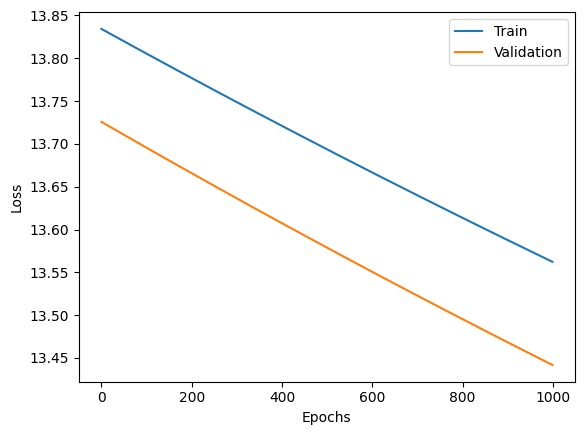

np.float64(3.666271254170027)

In [117]:
# Gradient Descent
W, errors, val_errors = fit(X_train, y_train, W, X_val, y_val, lr=0.0001, epochs=1000)

y_pred = predict(X_val, W)

plot_errors(errors, val_errors)

rmse(y_val, y_pred)

In [126]:
# Feature engineering

# Add polynomial features
def transform_input(X):
    X = np.hstack([X, X**2, np.sin(X), np.cos(X)])
    return X

X_train_poly = transform_input(X_train)
X_val_poly = transform_input(X_val)

X_train_poly.shape
W_poly = np.random.randn(X_train_poly.shape[1], 1)

In [153]:
W_poly = np.load('weights1.npy')

Epoch 0, Loss: 0.887516508686186, Val Loss: 0.8901316717695933
Epoch 1000, Loss: 0.8873680408005094, Val Loss: 0.8899724799714331
Epoch 2000, Loss: 0.8872226363816219, Val Loss: 0.889818403688561
Epoch 3000, Loss: 0.887080202881083, Val Loss: 0.8896692351864373
Epoch 4000, Loss: 0.886940651524212, Val Loss: 0.8895247760988856
Epoch 5000, Loss: 0.8868038971162454, Val Loss: 0.889384836965019
Epoch 6000, Loss: 0.8866698578603716, Val Loss: 0.8892492367913476
Epoch 7000, Loss: 0.8865384551867982, Val Loss: 0.8891178026375213
Epoch 8000, Loss: 0.8864096135920758, Val Loss: 0.8889903692242668
Epoch 9000, Loss: 0.8862832604879647, Val Loss: 0.888866778562189
Epoch 10000, Loss: 0.8861593260591862, Val Loss: 0.8887468796001933
Epoch 11000, Loss: 0.8860377431294598, Val Loss: 0.8886305278923772
Epoch 12000, Loss: 0.8859184470352618, Val Loss: 0.8885175852823185
Epoch 13000, Loss: 0.8858013755067966, Val Loss: 0.8884079196037482
Epoch 14000, Loss: 0.8856864685557031, Val Loss: 0.888301404396682


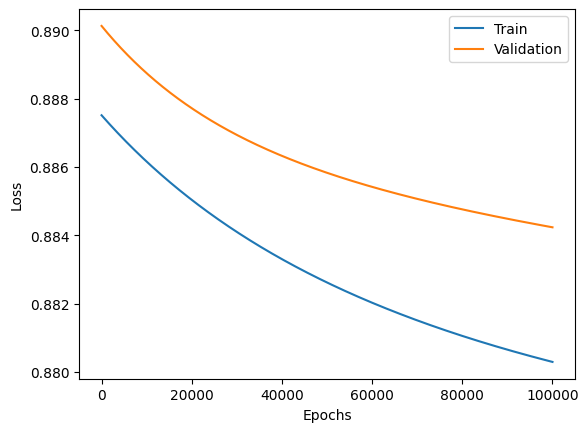

np.float64(0.940338501269005)

In [157]:
W_train_poly, errors, val_errors = fit(X_train_poly, y_train, W_poly, X_val_poly, y_val, lr=0.003, epochs=100000, print_every=1000)

plot_errors(errors, val_errors)

y_pred = predict(X_val_poly, W_train_poly)
rmse(y_val, y_pred)

In [159]:
# export weights
np.save('weights3.npy', W_train_poly)
W_backup = W_train_poly

In [160]:
X_val_poly = transform_input(X_val)
y_pred = predict(X_val_poly, W_poly)

rmse(y_val, y_pred)

np.float64(0.940338501269005)

In [161]:
X_test_poly = transform_input(X_test)
y_test_pred = predict(X_test_poly, W_poly)

rmse(y_test, y_test_pred)

np.float64(0.9308557733835064)

In [162]:
# Get output for final test data
X_final_test = np.array(test.drop('ID', axis=1))
X_final_test_poly = transform_input(X_final_test)
y_final_test = predict(X_final_test_poly, W_poly)
y_final_test = y_final_test.round()

output = pd.DataFrame({'ID': test['ID'], 'score': y_final_test.flatten()})

# output['score'] = output['score'].clip(0, 5)

# count score < 0
below0 = output[output['score'] < 0].shape[0]

# count score > 5
above5 = output[output['score'] > 5].shape[0]

print(output.shape[0], below0, above5)

output.to_csv('output.csv', index=False)

14996 0 1
